# VAR

In [1]:
import pandas as pd
import numpy as np

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX

## Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
# Import data
df = pd.read_csv('../Data/dataset_others.csv')

In [3]:
df

,Date,ALV_Open,ALV_Close,ALV_High,ALV_Low,ALV_Volume,ALV_Change,ALV_Gain,ALV_Loss,ALV_Avg_Gain,...,DNZOY_change_in_price,DNZOY_RSI,DNZOY_k_percent,DNZOY_r_percent,DNZOY_MACD,DNZOY_MACD_EMA,DNZOY_ROC,DNZOY_PVT,DNZOY_Bollinger_Upper,DNZOY_Bollinger_Lower
0,2019-11-22 00:00:00+00:00,80.980003,81.940002,82.019997,80.669998,361200.0,2.520004,2.520004,0.000000,0.556429,...,-0.175000,43.573069,9.649165,-90.350835,-0.024566,-0.008884,-2.023243,-152.544319,11.842262,11.222738
1,2019-11-25 00:00:00+00:00,82.250000,82.769997,82.860001,81.900002,356100.0,0.829994,0.829994,0.000000,0.485714,...,-0.020000,42.593532,6.140317,-93.859683,-0.031145,-0.013378,-2.489270,-162.386372,11.841552,11.224448
2,2019-11-26 00:00:00+00:00,82.580002,82.860001,83.470001,82.269997,347000.0,0.090004,0.090004,0.000000,0.492143,...,-0.045000,40.244797,0.000000,-100.000000,-0.038886,-0.018517,-3.947370,-215.467450,11.847754,11.201746
3,2019-11-27 00:00:00+00:00,82.760002,82.910004,83.360001,82.449997,252800.0,0.050003,0.050003,0.000000,0.384286,...,0.045000,43.819375,7.758622,-92.241378,-0.041372,-0.023115,-3.810337,-122.404982,11.848555,11.185945
4,2019-11-29 00:00:00+00:00,82.360001,81.720001,82.389999,81.449997,218400.0,-1.190002,0.000000,1.190002,0.358572,...,-0.155000,35.402535,2.127706,-97.872294,-0.053469,-0.029215,-3.778450,-286.137099,11.855746,11.140755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,2024-10-18 00:00:00+00:00,100.059998,99.519997,101.239998,98.099998,2354200.0,5.629997,5.629997,0.000000,0.792143,...,0.160000,33.078516,10.227235,-89.772765,-0.229944,-0.153725,-4.976145,-333708.504661,15.434049,13.693951
1233,2024-10-21 00:00:00+00:00,99.559998,96.800003,100.099998,96.660004,1381400.0,-2.719994,0.000000,2.719994,0.792143,...,-0.160000,28.537447,2.793305,-97.206695,-0.249203,-0.172821,-6.385873,-335921.415099,15.433712,13.585288
1234,2024-10-22 00:00:00+00:00,97.169998,97.400002,97.739998,96.599998,966500.0,0.599998,0.599998,0.000000,0.810000,...,-0.099999,25.966725,2.564101,-97.435899,-0.269430,-0.192142,-6.938772,-336840.858332,15.407882,13.479118
1235,2024-10-23 00:00:00+00:00,97.389999,96.500000,98.080002,95.709999,468700.0,-0.900002,0.000000,0.900002,0.810000,...,0.160000,36.523327,12.820505,-87.179495,-0.269443,-0.207602,-5.722072,-335645.537861,15.380513,13.410487


In [4]:
df.columns

Index(['Date', 'ALV_Open', 'ALV_Close', 'ALV_High', 'ALV_Low', 'ALV_Volume',
       'ALV_Change', 'ALV_Gain', 'ALV_Loss', 'ALV_Avg_Gain',
       ...
       'DNZOY_change_in_price', 'DNZOY_RSI', 'DNZOY_k_percent',
       'DNZOY_r_percent', 'DNZOY_MACD', 'DNZOY_MACD_EMA', 'DNZOY_ROC',
       'DNZOY_PVT', 'DNZOY_Bollinger_Upper', 'DNZOY_Bollinger_Lower'],
      dtype='object', length=199)

In [5]:
# Extract _change_in_price columns
change_in_price_cols = [col for col in df.columns if '_change_in_price' in col]

In [6]:
df_change = df[change_in_price_cols].copy()

In [7]:
df_change

,ALV_change_in_price,F_change_in_price,GM_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,WFC_change_in_price,X_change_in_price,ALI=F_change_in_price,DNZOY_change_in_price
0,2.520004,0.180000,0.660004,0.389999,0.000062,0.719997,0.580000,3.50,-0.175000
1,0.829994,0.110000,0.480000,0.009995,-0.000551,-0.070000,0.330000,-2.00,-0.020000
2,0.090004,0.010000,0.099998,-0.569992,-0.000812,-0.399998,-0.110000,18.00,-0.045000
3,0.050003,0.090000,0.230000,-0.309998,-0.000532,0.529999,0.250000,11.75,0.045000
4,-1.190002,-0.040000,-0.139999,-1.449997,0.000039,0.119999,-0.810000,-0.25,-0.155000
...,...,...,...,...,...,...,...,...,...
1232,5.629997,0.030001,-0.200001,0.330002,-0.000024,-0.019997,0.020000,62.50,0.160000
1233,-2.719994,-0.220000,-0.250000,-2.360001,-0.000072,-0.340004,1.099998,-24.75,-0.160000
1234,0.599998,0.230000,4.799999,0.759995,0.000026,0.790001,0.000000,33.00,-0.099999
1235,-0.900002,-0.049999,-0.810001,1.400009,-0.000006,-0.250000,0.590000,37.75,0.160000


## Granger-Causality

In [8]:
GC_stock = []
optimal_lag = []

for t in change_in_price_cols:
    df1 = df[['DNZOY_change_in_price', t]].copy()
    test_result = grangercausalitytests(df1.dropna(), maxlag=10)
    p_values = [round(test_result[i+1][0]['ssr_ftest'][1],4) for i in range(10)]
    min_p_value = np.min(p_values)
    if min_p_value < 0.05:
        GC_stock.append(t)
        optimal_lag.append(1 + np.argmin(p_values))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5296  , p=0.0021  , df_denom=1233, df_num=1
ssr based chi2 test:   chi2=9.5528  , p=0.0020  , df=1
likelihood ratio test: chi2=9.5161  , p=0.0020  , df=1
parameter F test:         F=9.5296  , p=0.0021  , df_denom=1233, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8102  , p=0.0004  , df_denom=1230, df_num=2
ssr based chi2 test:   chi2=15.6839 , p=0.0004  , df=2
likelihood ratio test: chi2=15.5852 , p=0.0004  , df=2
parameter F test:         F=7.8102  , p=0.0004  , df_denom=1230, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3336  , p=0.0012  , df_denom=1227, df_num=3
ssr based chi2 test:   chi2=16.0922 , p=0.0011  , df=3
likelihood ratio test: chi2=15.9882 , p=0.0011  , df=3
parameter F test:         F=5.3336  , p=0.0012  , df_denom=1227, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9989  , p=0.

In [9]:
GC_stock

['ALV_change_in_price',
 'F_change_in_price',
 'GM_change_in_price',
 'TM_change_in_price',
 'TRYUSD=X_change_in_price',
 'WFC_change_in_price',
 'ALI=F_change_in_price']

In [10]:
optimal_lag

[np.int64(2),
 np.int64(9),
 np.int64(8),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1)]

## ALV_change_in_price Granger-Causes DNZOY_change_in_price

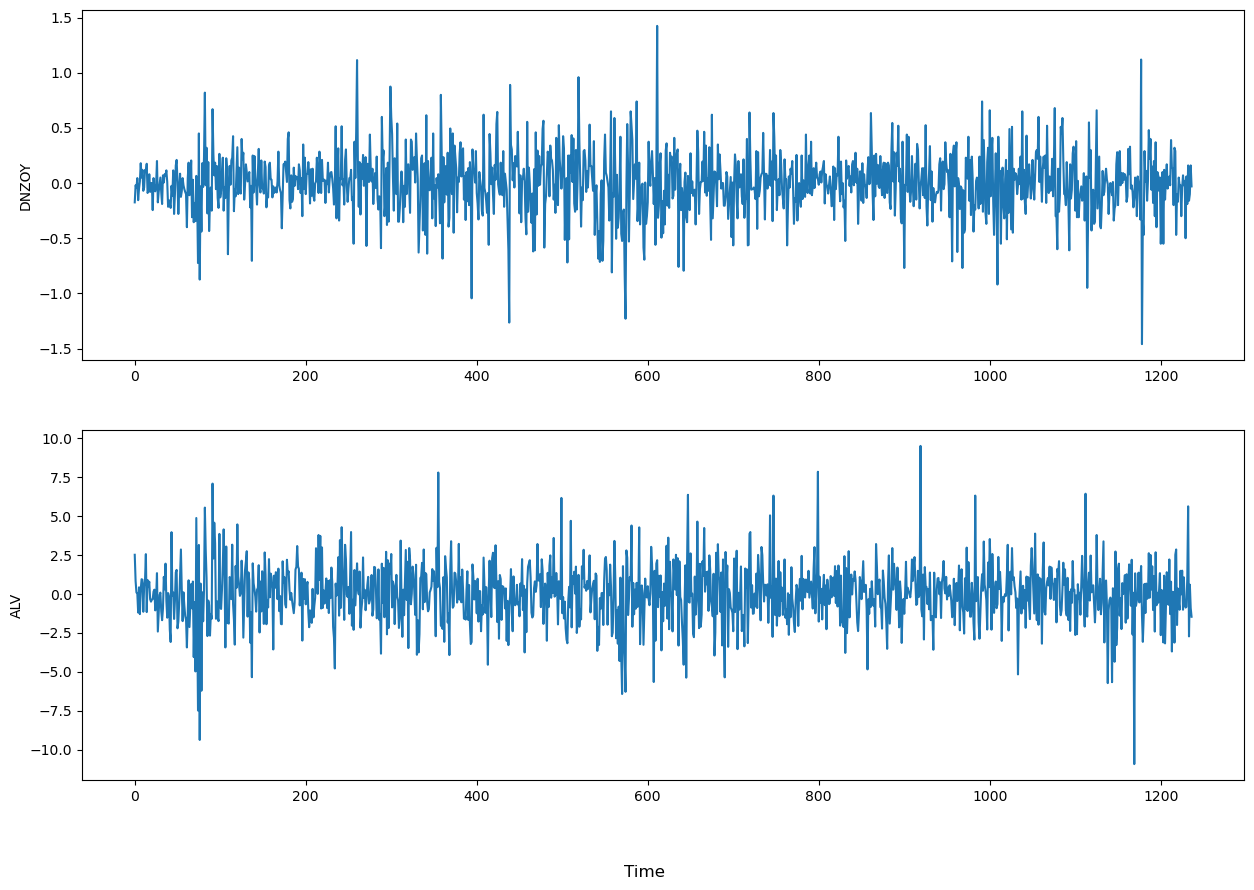

In [11]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['ALV_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('ALV')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='ALV_change_in_price', ylabel='DNZOY_change_in_price'>

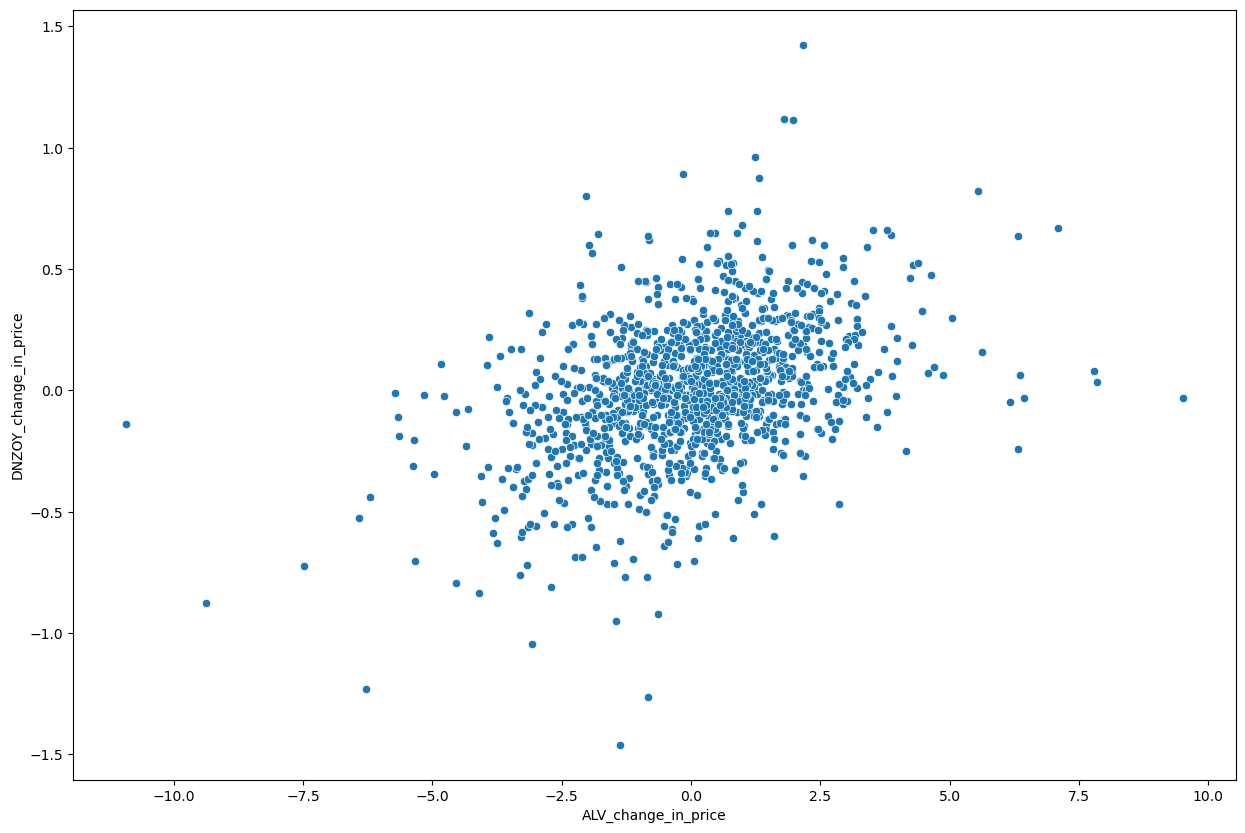

In [12]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'ALV_change_in_price', y = 'DNZOY_change_in_price')

In [13]:
df_change_ALV = df_change[['DNZOY_change_in_price', 'ALV_change_in_price']].copy()

In [14]:
df_change_ALV

,DNZOY_change_in_price,ALV_change_in_price
0,-0.175000,2.520004
1,-0.020000,0.829994
2,-0.045000,0.090004
3,0.045000,0.050003
4,-0.155000,-1.190002
...,...,...
1232,0.160000,5.629997
1233,-0.160000,-2.719994
1234,-0.099999,0.599998
1235,0.160000,-0.900002


In [15]:
forecast_length = 5

train_ALV = df_change_ALV.iloc[:-forecast_length]
test_ALV = df_change_ALV.iloc[-forecast_length:]

model_ALV = VAR(train_ALV)
sorted_order_ALV = model_ALV.select_order(maxlags = 10)
sorted_order_ALV.summary()

,AIC,BIC,FPE,HQIC
0,-1.426,-1.418*,0.2402,-1.423
1,-1.440,-1.415,0.2370,-1.430*
2,-1.440*,-1.398,0.2369*,-1.424
3,-1.434,-1.375,0.2384,-1.412
4,-1.427,-1.352,0.2399,-1.399
5,-1.424,-1.332,0.2407,-1.390
6,-1.423,-1.315,0.2409,-1.383
7,-1.420,-1.294,0.2418,-1.372
8,-1.416,-1.274,0.2426,-1.363
9,-1.416,-1.257,0.2427,-1.356


In [16]:
var_model_ALV = model_ALV.fit(10)
forecast_var_ALV = pd.DataFrame(var_model_ALV.forecast(train_ALV.values, 
                                              steps=forecast_length), 
                           columns=train_ALV.columns, 
                           index=test_ALV.index)
forecast_var_ALV = pd.concat([forecast_var_ALV['DNZOY_change_in_price'], test_ALV['DNZOY_change_in_price']], axis = 1)


In [17]:
forecast_var_ALV.columns = ['DNZOY Prediction','DNZOY True Value']
forecast_var_ALV

,DNZOY Prediction,DNZOY True Value
1232,0.056695,0.160000
1233,0.016759,-0.160000
1234,0.042466,-0.099999
1235,-0.013659,0.160000
1236,0.016398,-0.030000


## F_change_in_price Granger-Causes DNZOY_change_in_price

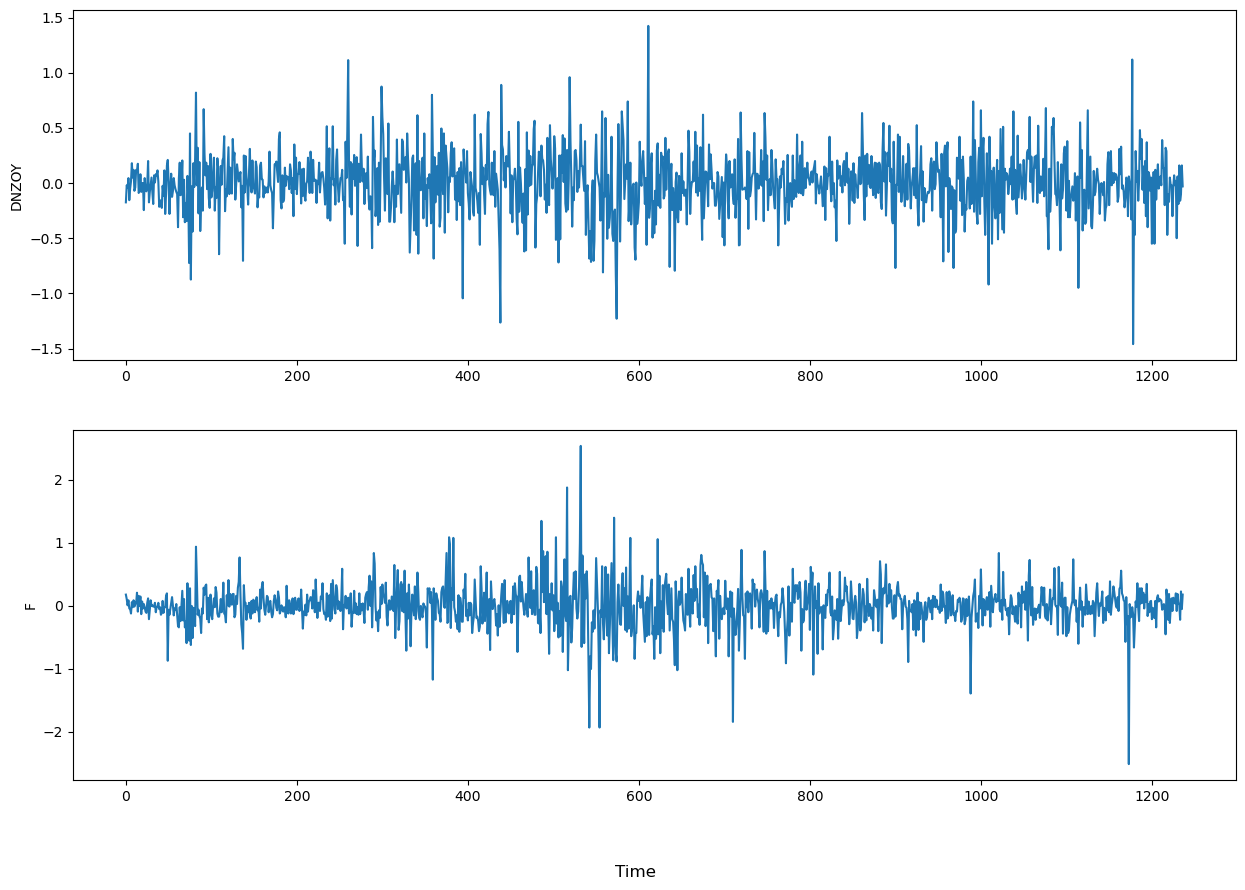

In [18]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['F_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('F')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='F_change_in_price', ylabel='DNZOY_change_in_price'>

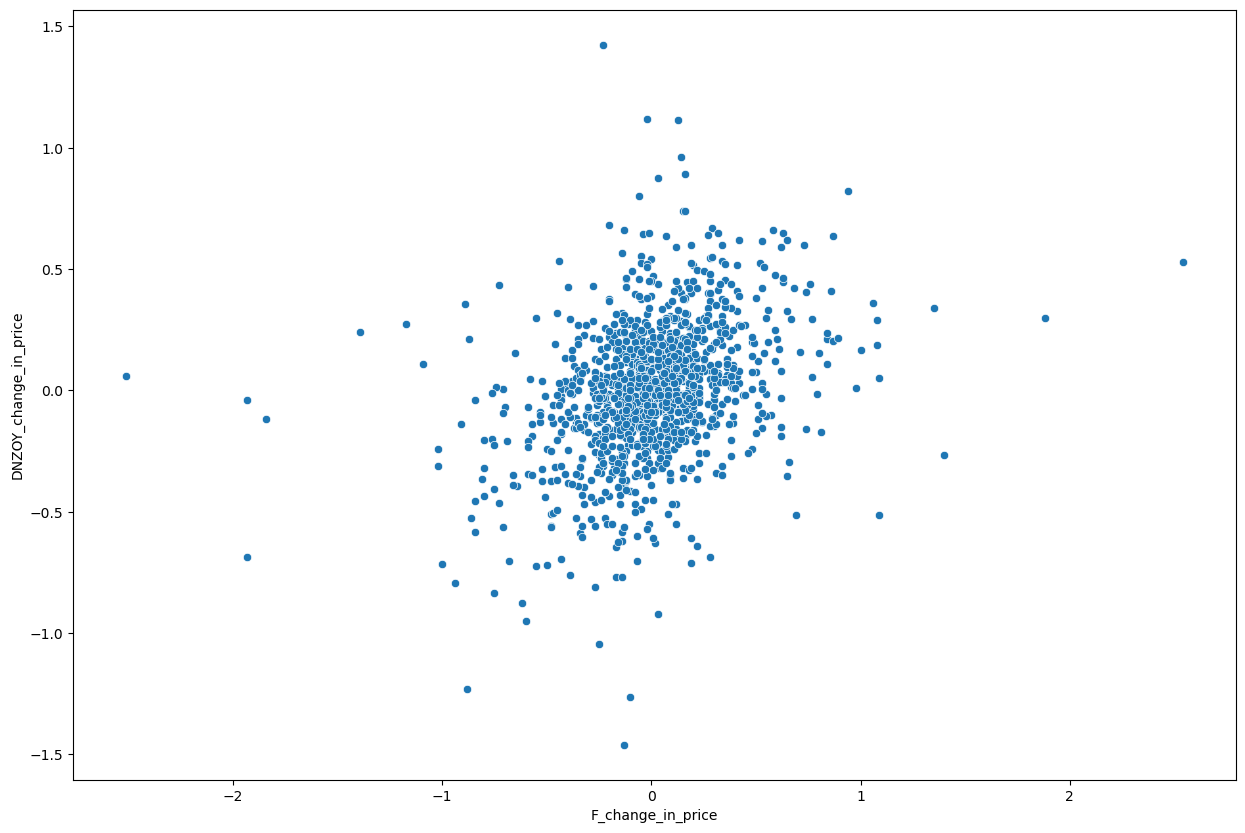

In [19]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'F_change_in_price', y = 'DNZOY_change_in_price')

In [20]:
df_change_F = df_change[['DNZOY_change_in_price', 'F_change_in_price']].copy()
train_F = df_change_F.iloc[:-forecast_length]
test_F = df_change_F.iloc[-forecast_length:]

model_F = VAR(train_F)
sorted_order_F = model_F.select_order(maxlags = 10)
sorted_order_F.summary()

,AIC,BIC,FPE,HQIC
0,-4.796,-4.788*,0.008264,-4.793*
1,-4.798*,-4.773,0.008245*,-4.789
2,-4.794,-4.752,0.008281,-4.778
3,-4.790,-4.731,0.008315,-4.768
4,-4.783,-4.708,0.008368,-4.755
5,-4.783,-4.691,0.008371,-4.748
6,-4.779,-4.670,0.008408,-4.738
7,-4.780,-4.655,0.008395,-4.733
8,-4.779,-4.637,0.008403,-4.726
9,-4.777,-4.618,0.008421,-4.717


In [21]:
var_model_F = model_F.fit(10)
forecast_var_F = pd.DataFrame(var_model_F.forecast(train_F.values, 
                                              steps=forecast_length), 
                           columns=train_F.columns, 
                           index=test_F.index)
forecast_var_F = pd.concat([forecast_var_F['DNZOY_change_in_price'], test_F['DNZOY_change_in_price']], axis = 1)
forecast_var_F.columns = ['DNZOY Prediction', 'DNZOY True Value']
forecast_var_F

,DNZOY Prediction,DNZOY True Value
1232,0.036772,0.160000
1233,0.027656,-0.160000
1234,0.013695,-0.099999
1235,0.024676,0.160000
1236,-0.016338,-0.030000


## GM_change_in_price Granger-Causes DNZOY_change_in_price

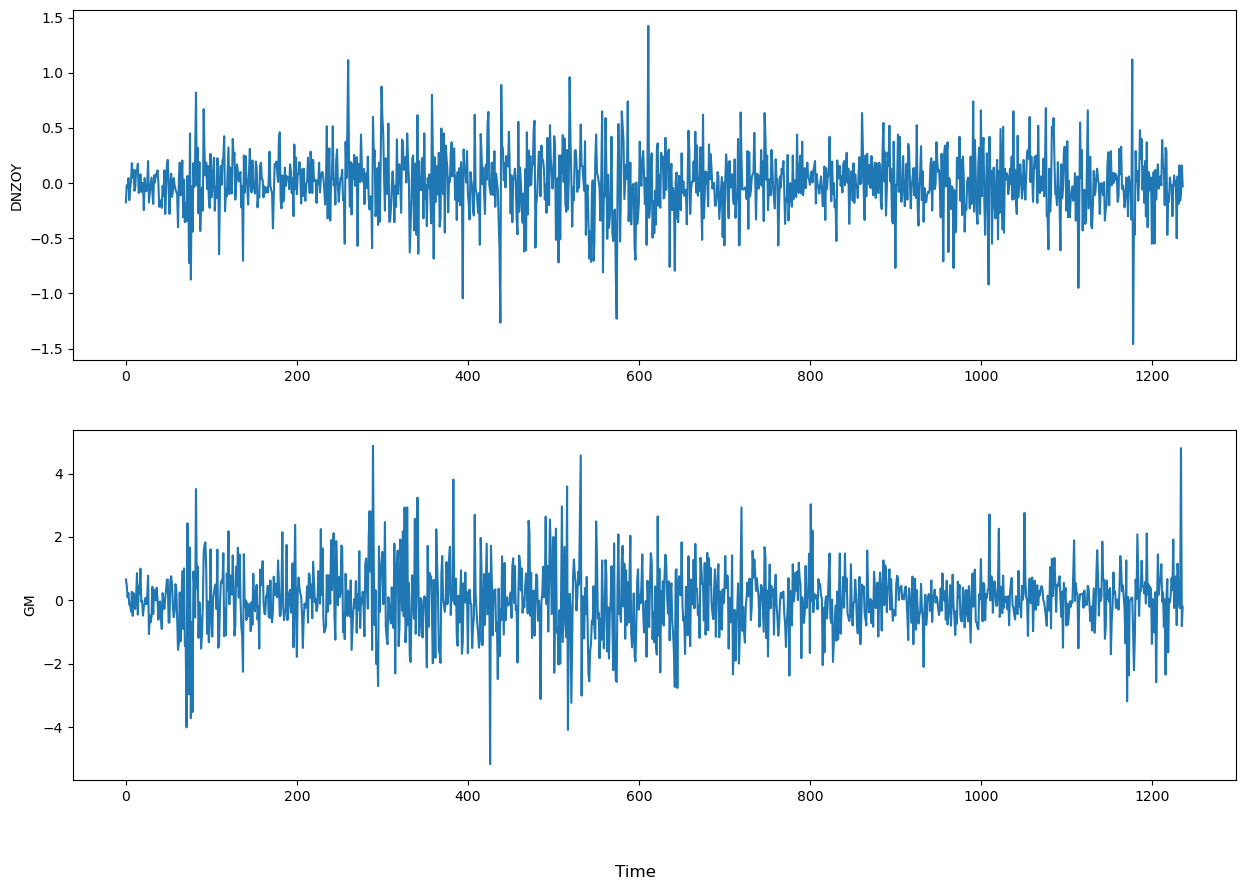

In [22]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['GM_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('GM')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='GM_change_in_price', ylabel='DNZOY_change_in_price'>

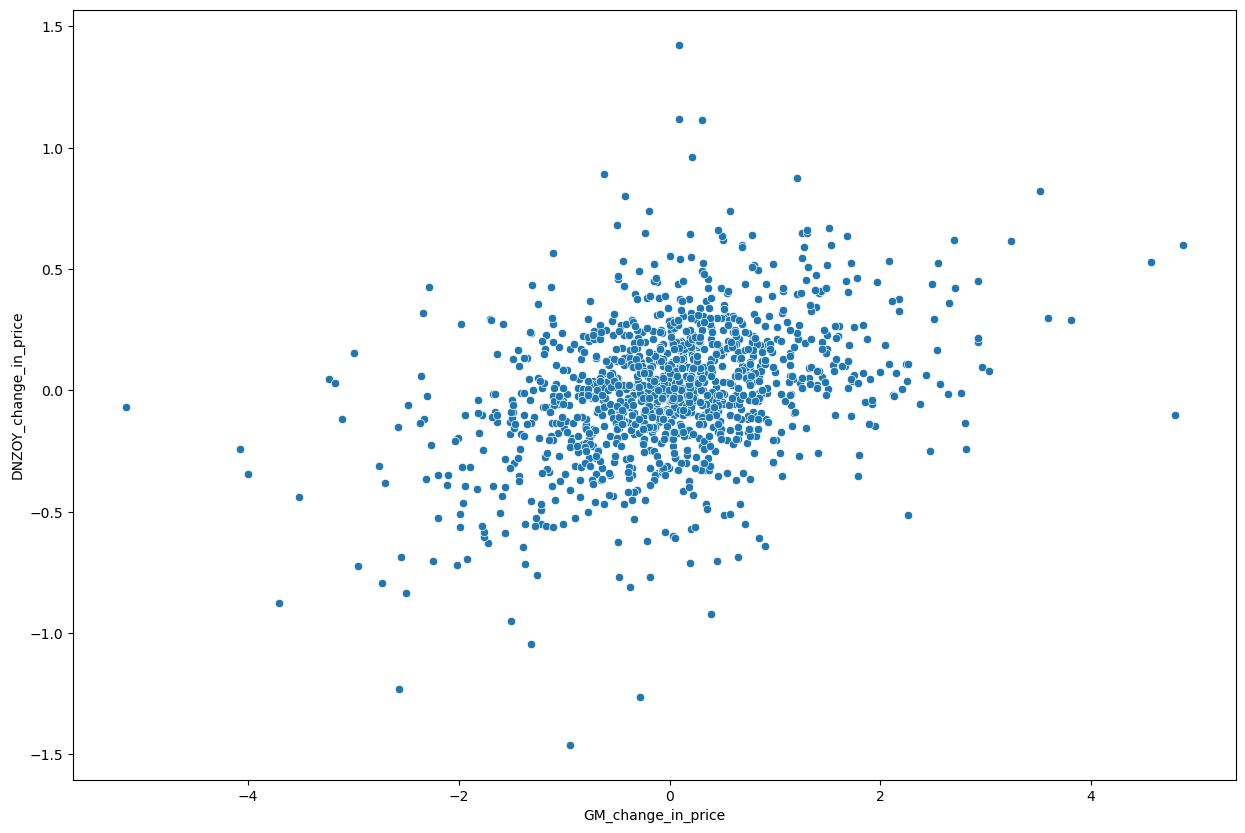

In [23]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'GM_change_in_price', y = 'DNZOY_change_in_price')

In [24]:
df_change_GM = df_change[['DNZOY_change_in_price', 'GM_change_in_price']].copy()
train_GM = df_change_GM.iloc[:-forecast_length]
test_GM = df_change_GM.iloc[-forecast_length:]

model_GM = VAR(train_GM)
sorted_order_GM = model_GM.select_order(maxlags = 10)
sorted_order_GM.summary()

,AIC,BIC,FPE,HQIC
0,-2.623,-2.615*,0.07258,-2.620*
1,-2.628*,-2.603,0.07219*,-2.619
2,-2.626,-2.584,0.07240,-2.610
3,-2.622,-2.563,0.07266,-2.600
4,-2.617,-2.542,0.07300,-2.589
5,-2.614,-2.522,0.07325,-2.579
6,-2.611,-2.502,0.07348,-2.570
7,-2.614,-2.488,0.07327,-2.566
8,-2.619,-2.477,0.07284,-2.566
9,-2.620,-2.462,0.07277,-2.561


In [25]:
var_model_GM = model_GM.fit(10)
forecast_var_GM = pd.DataFrame(var_model_GM.forecast(train_GM.values, 
                                              steps=forecast_length), 
                           columns=train_GM.columns, 
                           index=test_GM.index)
forecast_var_GM = pd.concat([forecast_var_GM['DNZOY_change_in_price'], test_GM['DNZOY_change_in_price']], axis = 1)
forecast_var_GM.columns = ['DNZOY Prediction', 'DNZOY True Value']
forecast_var_GM

,DNZOY Prediction,DNZOY True Value
1232,0.068524,0.160000
1233,0.002103,-0.160000
1234,0.031583,-0.099999
1235,0.018955,0.160000
1236,-0.047565,-0.030000


## TM_change_in_price Granger-Causes DNZOY_change_in_price

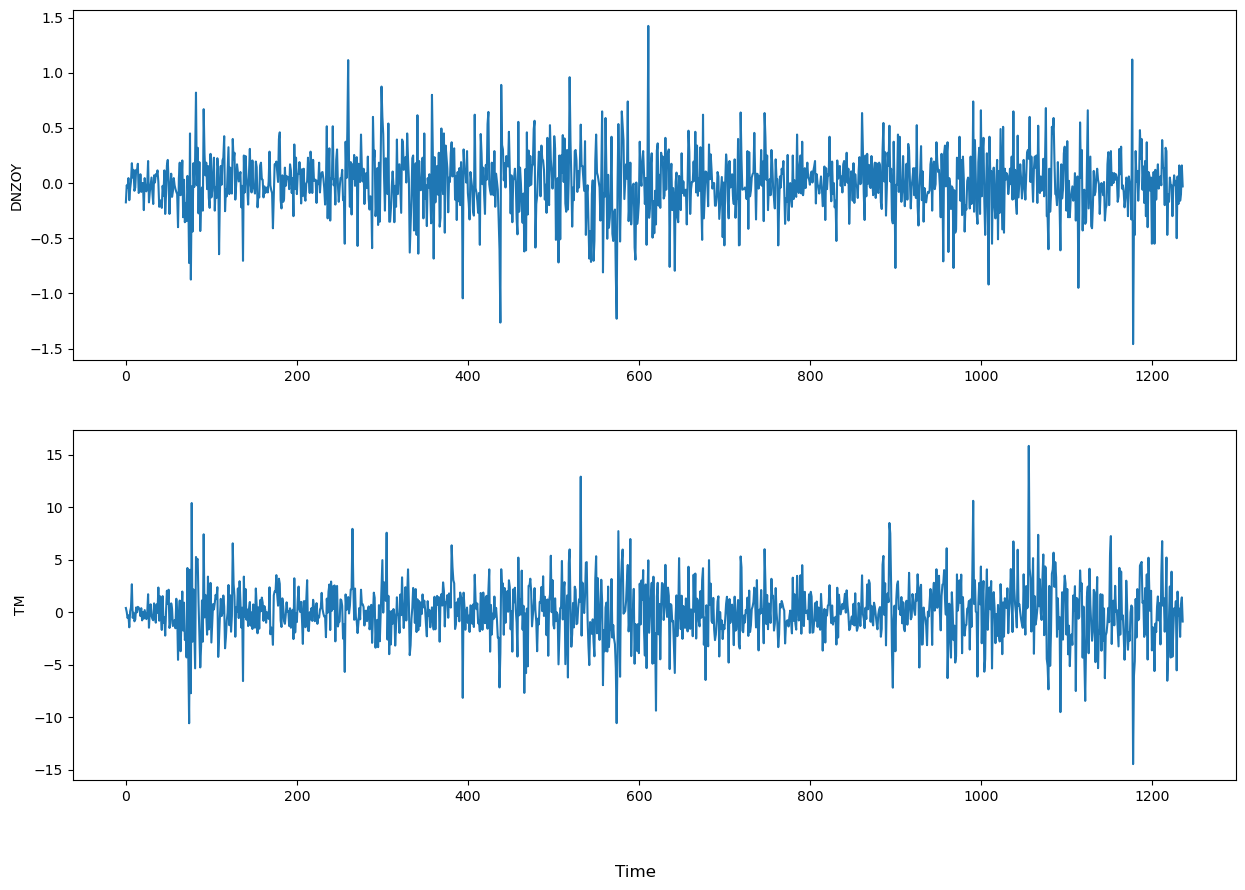

In [26]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['TM_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('TM')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='TM_change_in_price', ylabel='DNZOY_change_in_price'>

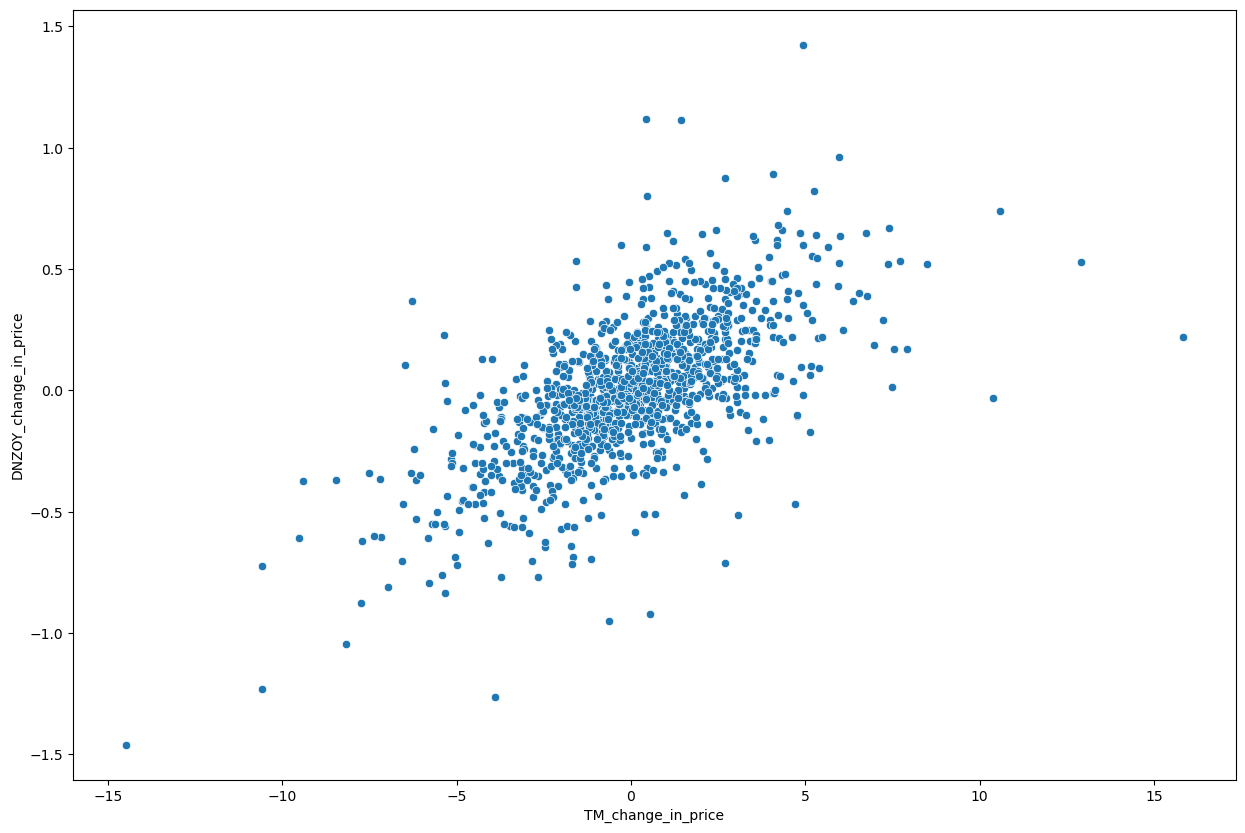

In [27]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'TM_change_in_price', y = 'DNZOY_change_in_price')

In [28]:
df_change_TM = df_change[['DNZOY_change_in_price', 'TM_change_in_price']].copy()
train_TM = df_change_TM.iloc[:-forecast_length]
test_TM = df_change_TM.iloc[-forecast_length:]

model_TM = VAR(train_TM)
sorted_order_TM = model_TM.select_order(maxlags = 10)
sorted_order_TM.summary()

,AIC,BIC,FPE,HQIC
0,-1.143,-1.134*,0.3190,-1.140
1,-1.150,-1.125,0.3167,-1.140*
2,-1.152*,-1.110,0.3159*,-1.136
3,-1.146,-1.087,0.3179,-1.124
4,-1.149,-1.074,0.3169,-1.121
5,-1.145,-1.053,0.3183,-1.110
6,-1.144,-1.035,0.3186,-1.103
7,-1.139,-1.014,0.3201,-1.092
8,-1.135,-0.9932,0.3213,-1.082
9,-1.129,-0.9702,0.3234,-1.069


In [29]:
var_model_TM = model_TM.fit(10)
forecast_var_TM = pd.DataFrame(var_model_TM.forecast(train_TM.values, 
                                              steps=forecast_length), 
                           columns=train_TM.columns, 
                           index=test_TM.index)
forecast_var_TM = pd.concat([forecast_var_TM['DNZOY_change_in_price'], test_TM['DNZOY_change_in_price']], axis = 1)
forecast_var_TM.columns = ['DNZOY Prediction', 'DNZOY True Value']
forecast_var_TM

,DNZOY Prediction,DNZOY True Value
1232,0.049654,0.160000
1233,0.008744,-0.160000
1234,0.001352,-0.099999
1235,0.024368,0.160000
1236,-0.047301,-0.030000


## TRYUSD_change_in_price Granger-Causes DNZOY_change_in_price

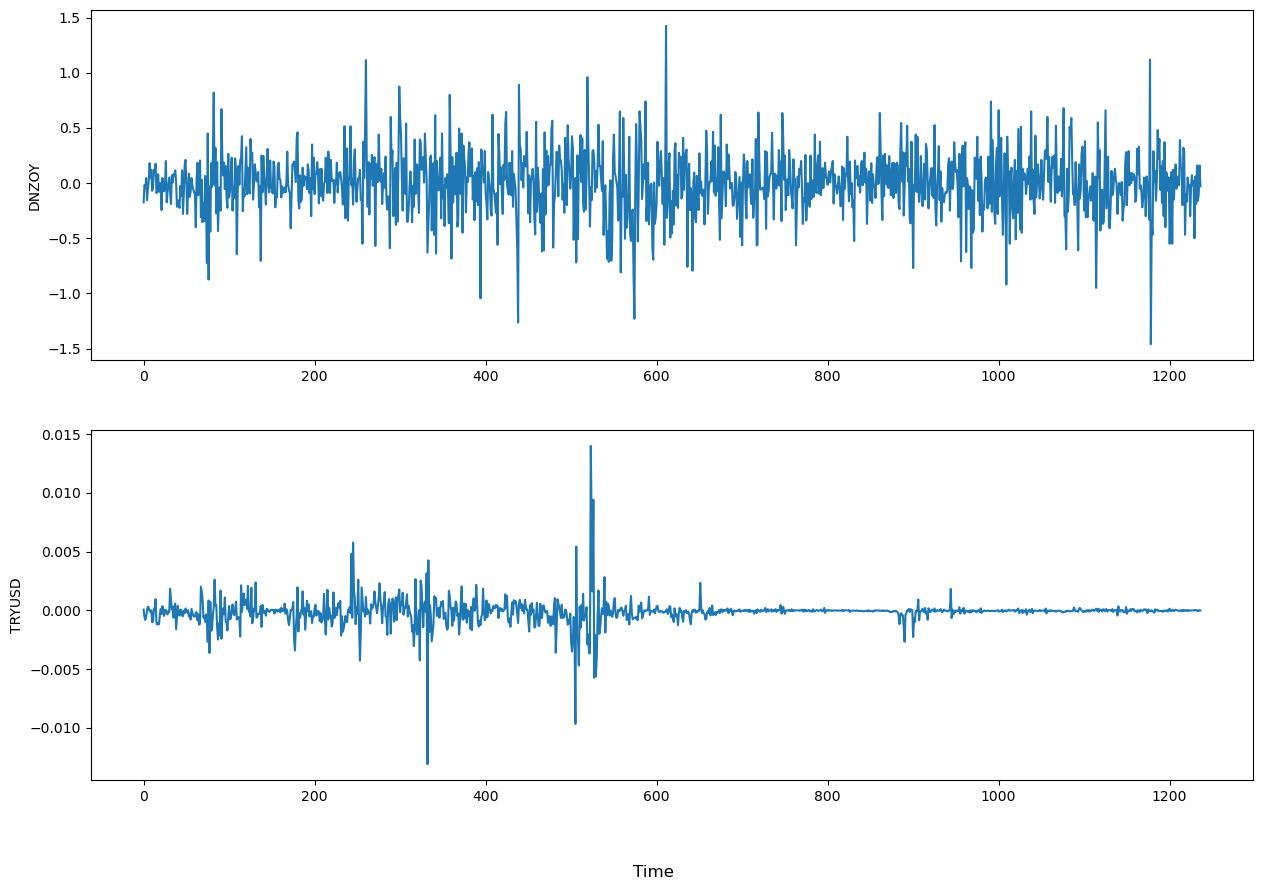

In [30]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['TRYUSD=X_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('TRYUSD')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='TRYUSD=X_change_in_price', ylabel='DNZOY_change_in_price'>

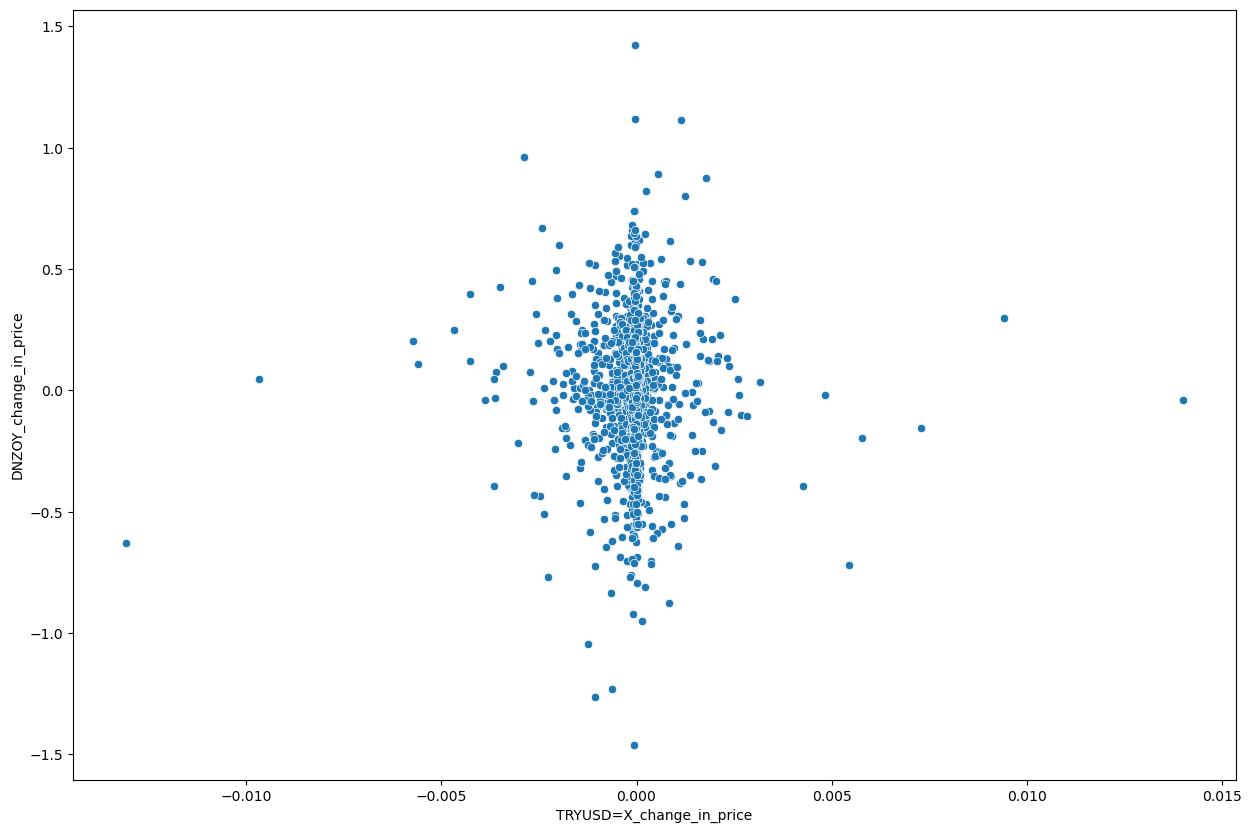

In [31]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'TRYUSD=X_change_in_price', y = 'DNZOY_change_in_price')

In [32]:
df_change_TRYUSD = df_change[['DNZOY_change_in_price', 'TRYUSD=X_change_in_price']].copy()
train_TRYUSD = df_change_TRYUSD.iloc[:-forecast_length]
test_TRYUSD = df_change_TRYUSD.iloc[-forecast_length:]

model_TRYUSD = VAR(train_TRYUSD)
sorted_order_TRYUSD = model_TRYUSD.select_order(maxlags = 10)
sorted_order_TRYUSD.summary()

,AIC,BIC,FPE,HQIC
0,-16.16,-16.15*,9.560e-08,-16.16*
1,-16.17,-16.14,9.519e-08,-16.16
2,-16.17*,-16.13,9.478e-08*,-16.16
3,-16.17,-16.11,9.535e-08,-16.14
4,-16.17,-16.10,9.488e-08,-16.14
5,-16.17,-16.07,9.532e-08,-16.13
6,-16.16,-16.05,9.587e-08,-16.12
7,-16.15,-16.03,9.639e-08,-16.11
8,-16.15,-16.01,9.675e-08,-16.10
9,-16.15,-15.99,9.676e-08,-16.09


In [33]:
var_model_TRYUSD = model_TRYUSD.fit(10)
forecast_var_TRYUSD = pd.DataFrame(var_model_TRYUSD.forecast(train_TRYUSD.values, 
                                              steps=forecast_length), 
                           columns=train_TRYUSD.columns, 
                           index=test_TRYUSD.index)
forecast_var_TRYUSD = pd.concat([forecast_var_TRYUSD['DNZOY_change_in_price'], test_TRYUSD['DNZOY_change_in_price']], axis = 1)
forecast_var_TRYUSD.columns = ['DNZOY Prediction', 'DNZOY True Value']
forecast_var_TRYUSD

,DNZOY Prediction,DNZOY True Value
1232,0.004050,0.160000
1233,0.004043,-0.160000
1234,-0.001499,-0.099999
1235,0.007029,0.160000
1236,-0.013277,-0.030000


## WFC_change_in_price Granger-Causes DNZOY_change_in_price

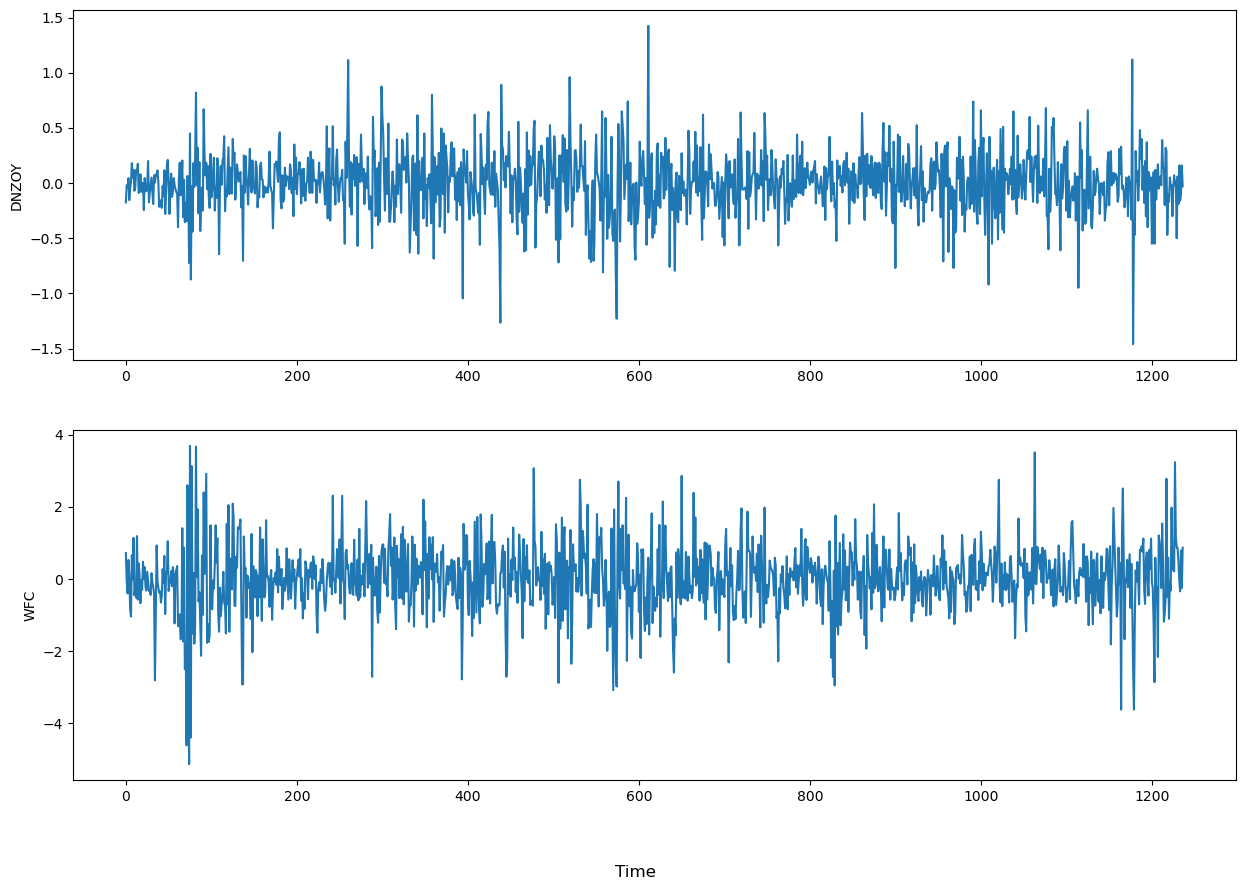

In [34]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['WFC_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('WFC')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='WFC_change_in_price', ylabel='DNZOY_change_in_price'>

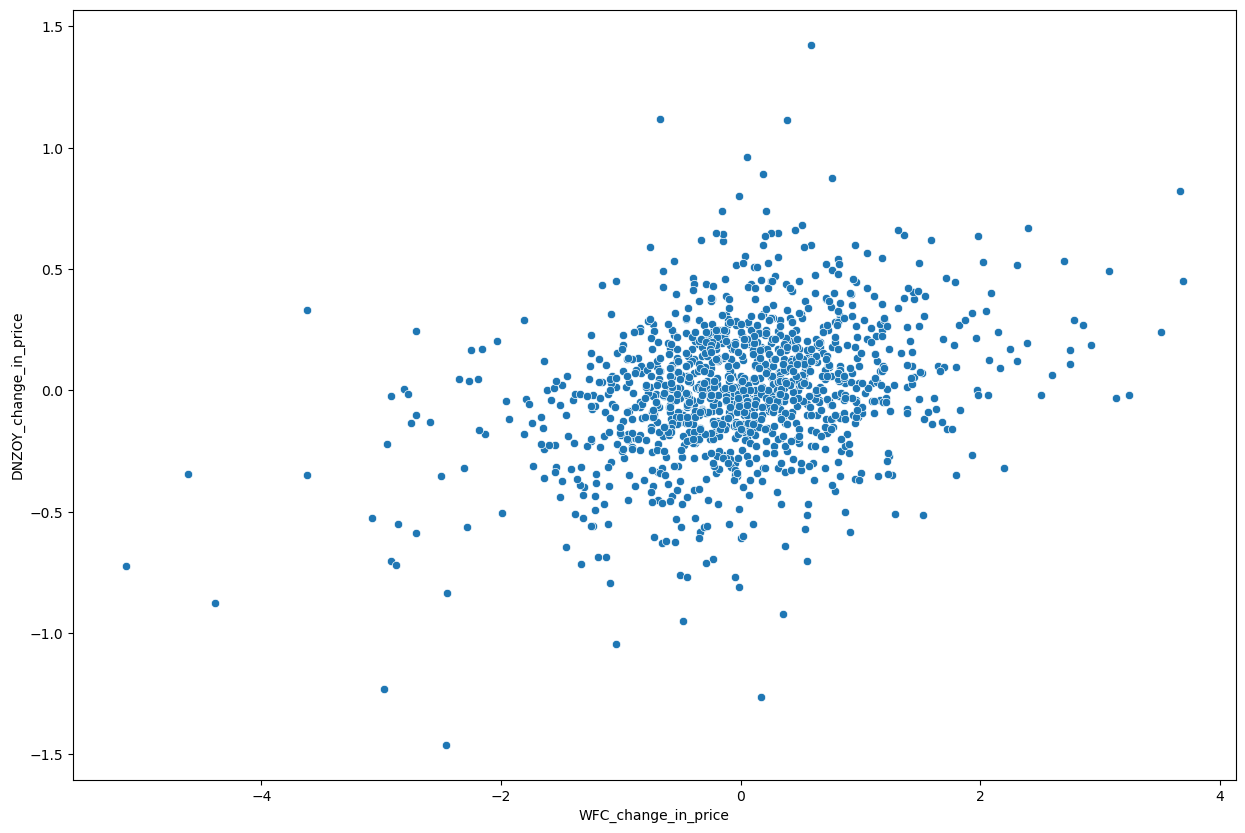

In [35]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'WFC_change_in_price', y = 'DNZOY_change_in_price')

In [36]:
df_change_WFC = df_change[['DNZOY_change_in_price', 'WFC_change_in_price']].copy()
train_WFC = df_change_WFC.iloc[:-forecast_length]
test_WFC = df_change_WFC.iloc[-forecast_length:]

model_WFC = VAR(train_WFC)
sorted_order_WFC = model_WFC.select_order(maxlags = 10)
sorted_order_WFC.summary()

,AIC,BIC,FPE,HQIC
0,-2.767,-2.759*,0.06284,-2.764*
1,-2.768*,-2.743,0.06281*,-2.758
2,-2.767,-2.725,0.06287,-2.751
3,-2.761,-2.703,0.06321,-2.739
4,-2.755,-2.680,0.06359,-2.727
5,-2.752,-2.660,0.06383,-2.717
6,-2.747,-2.638,0.06412,-2.706
7,-2.750,-2.624,0.06395,-2.703
8,-2.745,-2.603,0.06423,-2.692
9,-2.740,-2.581,0.06457,-2.680


In [37]:
var_model_WFC = model_WFC.fit(10)
forecast_var_WFC = pd.DataFrame(var_model_WFC.forecast(train_WFC.values, 
                                              steps=forecast_length), 
                           columns=train_WFC.columns, 
                           index=test_WFC.index)
forecast_var_WFC = pd.concat([forecast_var_WFC['DNZOY_change_in_price'], test_WFC['DNZOY_change_in_price']], axis = 1)
forecast_var_WFC.columns = ['DNZOY Prediction', 'DNZOY True Value']
forecast_var_WFC

,DNZOY Prediction,DNZOY True Value
1232,0.065864,0.160000
1233,0.004821,-0.160000
1234,0.026625,-0.099999
1235,0.018778,0.160000
1236,0.015252,-0.030000


## ALI=F_change_in_price Granger-Causes DNZOY_change_in_price

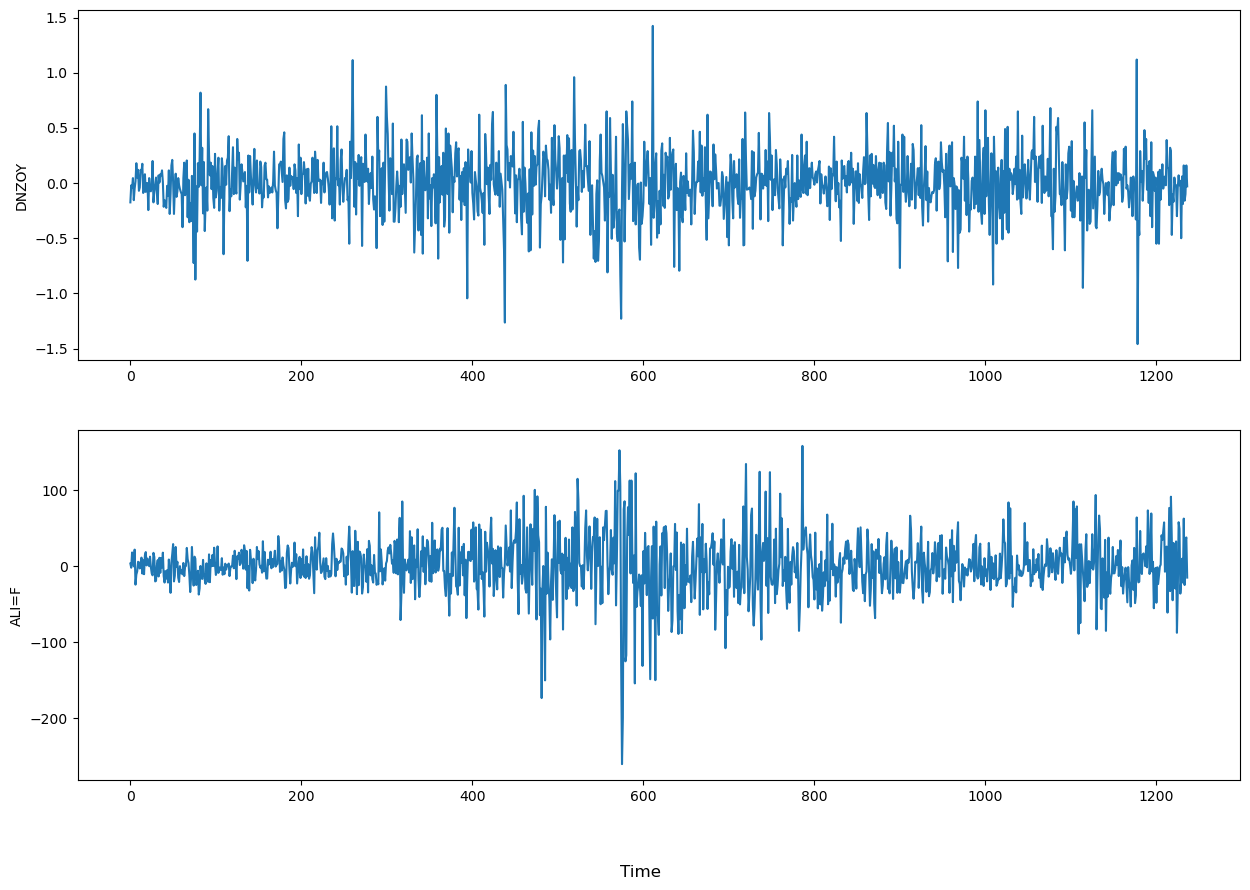

In [38]:
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(df_change['DNZOY_change_in_price'])
ax[1].plot(df_change['ALI=F_change_in_price'])
ax[0].set_ylabel('DNZOY')
ax[1].set_ylabel('ALI=F')
fig.supxlabel('Time')
plt.show()

<Axes: xlabel='ALI=F_change_in_price', ylabel='DNZOY_change_in_price'>

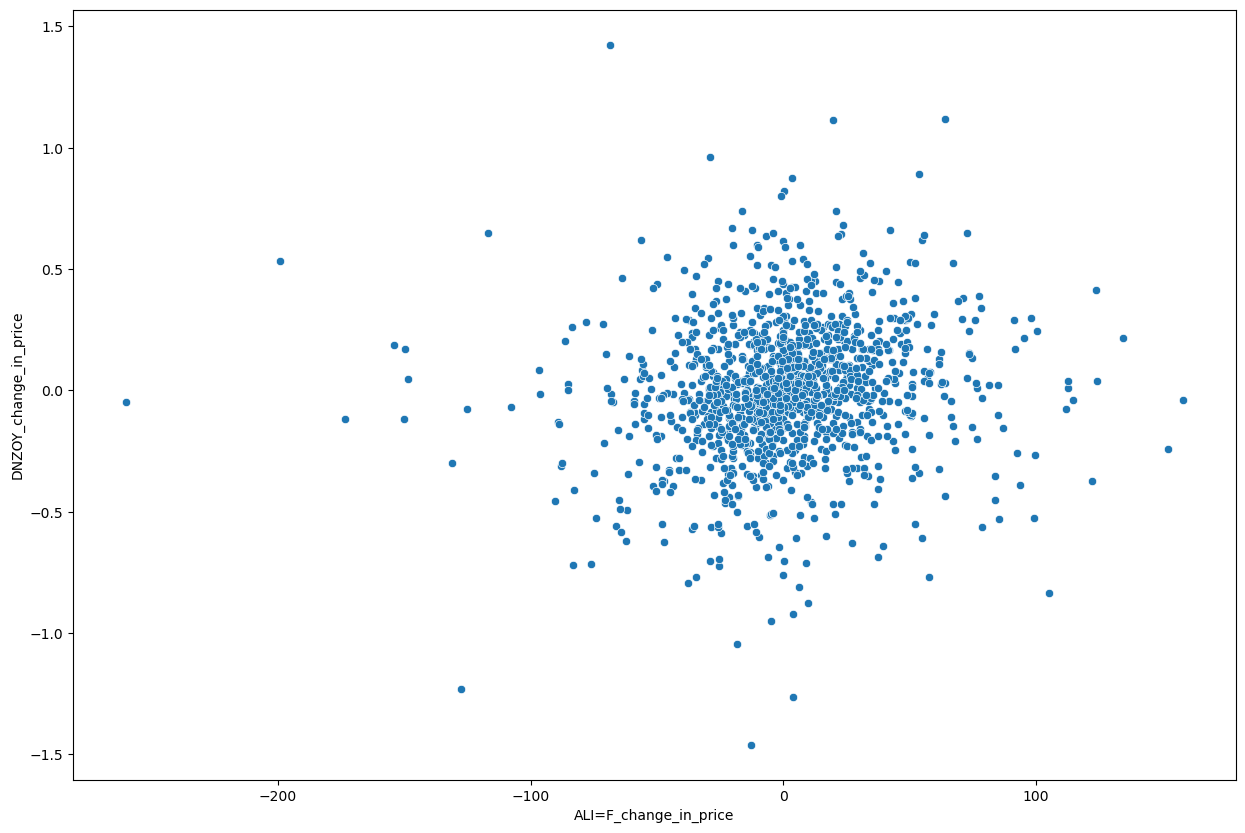

In [39]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df_change, x = 'ALI=F_change_in_price', y = 'DNZOY_change_in_price')

In [40]:
df_change_ALI = df_change[['DNZOY_change_in_price', 'ALI=F_change_in_price']].copy()
train_ALI = df_change_ALI.iloc[:-forecast_length]
test_ALI = df_change_ALI.iloc[-forecast_length:]

model_ALI = VAR(train_ALI)
sorted_order_ALI = model_ALI.select_order(maxlags = 10)
sorted_order_ALI.summary()

,AIC,BIC,FPE,HQIC
0,4.680,4.688,107.7,4.683
1,4.658*,4.683*,105.4*,4.667*
2,4.663,4.705,106.0,4.679
3,4.664,4.723,106.1,4.686
4,4.665,4.740,106.2,4.693
5,4.668,4.760,106.5,4.702
6,4.668,4.777,106.5,4.709
7,4.672,4.797,106.9,4.719
8,4.675,4.817,107.3,4.729
9,4.680,4.839,107.8,4.740


In [41]:
var_model_ALI = model_ALI.fit(10)
forecast_var_ALI = pd.DataFrame(var_model_ALI.forecast(train_ALI.values, 
                                              steps=forecast_length), 
                           columns=train_ALI.columns, 
                           index=test_ALI.index)
forecast_var_ALI = pd.concat([forecast_var_ALI['DNZOY_change_in_price'], test_ALI['DNZOY_change_in_price']], axis = 1)
forecast_var_ALI.columns = ['DNZOY Prediction', 'DNZOY True Value']
forecast_var_ALI

,DNZOY Prediction,DNZOY True Value
1232,0.013710,0.160000
1233,-0.059531,-0.160000
1234,0.020670,-0.099999
1235,0.047824,0.160000
1236,-0.014115,-0.030000


In [42]:
acc = sum(forecast_var_ALI['DNZOY Prediction']*forecast_var_ALI['DNZOY True Value'] > 0)/forecast_length

In [43]:
acc

0.8

## Train_test_split

In [44]:
train = df_change_ALI.iloc[:-forecast_length]
test = df_change_ALI.iloc[-forecast_length:]

In [98]:
cv = TimeSeriesSplit(10, test_size=forecast_length)
MSE = np.zeros(9)

for train_index, test_index in cv.split(train):
    t_tt = train.iloc[train_index]
    t_ho = train.iloc[test_index]
    model = VAR(t_tt)
    for i in range(1, 10):
        var_model = model.fit(i)
        pred = var_model.forecast(t_tt.values, steps=forecast_length)
        MSE[i - 1] = np.sqrt(mean_squared_error(t_ho['DNZOY_change_in_price'].values, pred[:, 0]))

order_optimal = np.argmin(MSE) + 1

## Apply the order optimal to the test set

In [101]:
model_best = VAR(train)
var_model_best = model.fit(order_optimal)
pred_best = var_model.forecast(train.values, steps=forecast_length)
pred_best

array([[ 4.65395299e-03,  5.46059726e+00],
       [-4.99594948e-02, -8.36523965e+00],
       [-3.11451188e-03, -2.50819221e+00],
       [ 3.93464934e-02, -4.44771741e+00],
       [ 1.44070945e-04,  3.99949814e+00]])

In [102]:
test

,DNZOY_change_in_price,ALI=F_change_in_price
1232,0.160000,62.50
1233,-0.160000,-24.75
1234,-0.099999,33.00
1235,0.160000,37.75
1236,-0.030000,-15.00


In [85]:
np.sqrt(mean_squared_error(t_ho['DNZOY_change_in_price'].values, pred[:, 0]))

np.float64(0.24363409660613103)

In [63]:
pred

array([[-1.47189658e-02,  1.83605460e+00],
       [-4.65620775e-02,  9.23430606e-01],
       [ 4.88462135e-02, -2.26719135e+01],
       [-5.37152066e-02, -6.43984447e-01],
       [ 3.54691889e-02,  7.68526420e+00]])

In [94]:
MSE

array([0.2422987 , 0.24224633, 0.24257524, 0.24220301, 0.24219753,
       0.23588533, 0.23997185, 0.23945841, 0.2436341 ])

In [96]:
np.argmin(MSE)

np.int64(5)

In [64]:
pred[:, 0]

array([-0.01471897, -0.04656208,  0.04884621, -0.05371521,  0.03546919])

In [51]:
t_ho

,DNZOY_change_in_price,ALI=F_change_in_price
1227,-0.020000,49.00
1228,0.020000,-36.00
1229,-0.500000,-18.25
1230,0.060000,9.75
1231,-0.190001,-21.50
